In [ ]:
import torch,torchvision,os,time
import torchvision.transforms as transforms
import numpy as np
from utils.util import get_loader,evaluate
from utils.layer import qConv2d,qLinear
from utils.train import QAVAT_train
import matplotlib.pyplot as plt
import torchvision.models as models                           # for example model
from mqbench.prepare_by_platform import prepare_by_platform   # add quant nodes for specific Backend
from mqbench.prepare_by_platform import BackendType           # contain various Backend, like TensorRT, NNIE, etc.
from mqbench.utils.state import enable_calibration            # turn on calibration algorithm, determine scale, zero_point, etc.
from mqbench.utils.state import enable_quantization           # turn on actually quantization, like FP32 -> INT8
from mqbench.utils.state import disable_all           # turn on actually quantization, like FP32 -> INT8
from copy import deepcopy

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True).cuda()
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_mobilenetv2_x0_5", pretrained=True).cuda()

In [ ]:
train,test = get_loader('cifar10'.upper(),batch_size=128,test_batch_size=128)
train.num_workers = 2
test.num_workers = 2
train.pin_in_memory = True
test.pin_in_memory = True

In [ ]:
# calibration data used to calibrate PTQ and MPQ
calib_data = []
i = 0
for img,label in train:
    i += 1
    calib_data.append((img,label))
    if i == 8:
        break

In [ ]:
model.eval()
mqb_model = deepcopy(model)
torch_fp_model = deepcopy(model)
torch_quantized_model = deepcopy(model)
torch_perturb_model = deepcopy(model)
model = None

In [ ]:
# MSE calibration on model parameters
backend = BackendType.Academic
extra_config = {
    'extra_qconfig_dict': {
        'w_observer': 'MSEObserver',                              # custom weight observer
        'a_observer': 'EMAMSEObserver',                              # custom activation observer
        'w_fakequantize': 'FixedFakeQuantize',                    # custom weight fake quantize function
        'a_fakequantize': 'FixedFakeQuantize',                    # custom activation fake quantize function
        'w_qscheme': {
            'bit': 4,                                             # custom bitwidth for weight,
            'symmetry': True,                                    # custom whether quant is symmetric for weight,
            'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for weight,
            'pot_scale': False,                                   # custom whether scale is power of two for weight.
        },
        'a_qscheme': {
            'bit': 8,                                             # custom bitwidth for activation,
            'symmetry': False,                                    # custom whether quant is symmetric for activation,
            'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for activation,
            'pot_scale': False,                                   # custom whether scale is power of two for activation.
        }
    }                                                         # custom tracer behavior, checkout https://github.com/pytorch/pytorch/blob/efcbbb177eacdacda80b94ad4ce34b9ed6cf687a/torch/fx/_symbolic_trace.py#L836
}

In [ ]:
mqb_model = prepare_by_platform(mqb_model, backend,extra_config).cuda()

In [ ]:
# calibration loop
enable_calibration(mqb_model)
for img,label in calib_data:
    mqb_model(img.cuda())  

In [ ]:
# evaluation loop
from mqbench.utils.state import disable_all
enable_quantization(mqb_model)
#disable_all(mqb_model)
evaluate(test,mqb_model)

In [ ]:
evaluate(test,torch_fp_model)

In [ ]:
def getModuleByName(modelName,moduleName):
    '''
        replace module with name modelName.moduleName with newModule
    '''
    tokens = moduleName.split('.')
    eval_str = modelName
    for token in tokens:
        try:
            eval_str += f'[{int(token)}]'
        except:
            eval_str += f'.{token}'
            
    return eval(eval_str)

# pass quantized weight to torch_quantized_model
for n,m in mqb_model.named_modules():
    if isinstance(m,torch.nn.Linear) or isinstance(m,torch.nn.Conv2d):
        # print('loading quantized weight for layer',n)
        torch_module = getModuleByName('torch_quantized_model',n)
        torch_module.weight.data = m.weight_fake_quant(m.weight).data

In [ ]:
evaluate(test,torch_quantized_model) 

In [ ]:
mqb_model = None

## FeintLady

In [ ]:
from collections import OrderedDict
# 1. record all modules we want to consider
layers_to_quant = OrderedDict() # layer_name:[torch_fp_module,torch_q_module,torch_p_module]
types_to_quant = (torch.nn.Conv2d,torch.nn.Linear)

for n,m in torch_fp_model.named_modules():
    if isinstance(m,types_to_quant):
        layers_to_quant[n] = [m,]
        
for n,m in torch_quantized_model.named_modules():
    if isinstance(m,types_to_quant):
        layers_to_quant[n].append(m)

for n,m in torch_perturb_model.named_modules():
    if isinstance(m,types_to_quant):
        layers_to_quant[n].append(m)

In [ ]:
res = evaluate(calib_data,torch_fp_model)
ref_metric = ('mean_loss',res['mean_loss'])

In [ ]:
res

In [ ]:
def perturb_loss(perturb_names,ref_metric,eval_data,printInfo=False):
    with torch.no_grad():
        # perturb layers
        for n in perturb_names:
            layers_to_quant[n][2].weight.data = layers_to_quant[n][1].weight.data
        # do evaluation
        res = evaluate(eval_data,torch_perturb_model)
        perturbed_loss = res[ref_metric[0]] - ref_metric[1]
        
        if printInfo:
            print(res)
        # recover layers
        for n in perturb_names:
            layers_to_quant[n][2].weight.data = layers_to_quant[n][0].weight.data
    return perturbed_loss

## Build Cached Grad if not done before

In [ ]:
import time
s_time = time.time()
cached = {}
for n in layers_to_quant:
    for m in layers_to_quant:
        if n == m:
            print('perturb layer',n)
            p = perturb_loss([n,],ref_metric,calib_data)
            cached[(n,n)] = p
        if (n,m) not in cached:
            print('perturb layer',n,m)
            p = perturb_loss([n,m],ref_metric,calib_data)
            cached[(n,m)] = p
            cached[(m,n)] = p   
print(f'{time.time()-s_time:.2f} seconds elapsed')

In [ ]:
layer_index = {}
cnt = 0
for layer in layers_to_quant:
    layer_index[layer] = cnt
    cnt += 1
L = cnt

In [ ]:
import numpy as np
hm = np.zeros(shape=(L,L))
for n in layers_to_quant:
    for m in layers_to_quant:
        hm[layer_index[n],layer_index[m]] = cached[(n,m)]

In [ ]:
cached_grad = np.zeros_like(hm)

In [ ]:
import pickle
with open('feintlady_c100resnet56_calib','wb') as f:
    pickle.dump({'Ltilde':hm,'layer_index':layer_index},f)

In [ ]:
perturb_loss(['conv1',],ref_metric,eval_data=calib_data)

## Load Cached Grad

In [ ]:
import pickle
with open('feintlady_resnet56_calib','rb') as f:
    hm = pickle.load(f)

In [ ]:
plt.imshow(hm['Ltilde'],cmap='hot')

In [ ]:
L = hm['Ltilde'].shape[0]
cached_grad = np.zeros_like(hm['Ltilde'])
for i in range(L):
    for j in range(L):
        if i == j:
            cached_grad[i,j] = 0.5 * hm['Ltilde'][i,j]
        else:
            cached_grad[i,j] = 0.25 * (hm['Ltilde'][i,j]-hm['Ltilde'][i,i]-hm['Ltilde'][j,j])

In [ ]:
cached_grad

In [ ]:
# cached_grad[cached_grad<0]=0
plt.imshow(cached_grad)

### Define a naive cost function: model size

In [ ]:
layer_size = np.array([0 for i in range(L)])
for l in hm['layer_index']:
    layer_size[hm['layer_index'][l]] = torch.numel(layers_to_quant[l][0].weight)

In [ ]:
layer_size
tot_size =  layer_size.sum()

In [ ]:
# initialize random variable v
# use recitfied sigmoid h(v) to represent alpha
# freg is 1-(1-2h(v))**beta, annealing beta to 

if not isinstance(cached_grad,torch.Tensor):
    cached_grad = torch.Tensor(cached_grad)

layer_size_tensor = torch.Tensor(layer_size)

def lossfunc(v,beta,lambda1,lambda2,printInfo=False,naive=False,b=None):
    alpha = (torch.sigmoid(v) * 1.2 - 0.1).clamp(0,1)
    if not naive:
        
        outer_alpha = torch.outer(alpha,alpha)
        netloss = torch.sum(outer_alpha * cached_grad)
    else:
        netloss = torch.sum(torch.diagonal(cached_grad) * alpha)
            
    regloss = torch.sum(1-(torch.abs(1-2*alpha))**beta)
    regloss *= lambda1
    
    if b is None:
        closs = -lambda2 * torch.sum(layer_size_tensor * alpha)
    else:
        closs = torch.sum(layer_size_tensor * alpha * 4) + torch.sum(layer_size_tensor * (1-alpha) * 8)
        closs = torch.clamp(closs-b,0)
        closs *= lambda2
        
    
    totloss = netloss + regloss + closs
    
    if printInfo:
        print(f'netloss {netloss.item():.4f} regloss {regloss.item():.4f}(beta={beta:.4f}) closs{closs.item():.4f}(constraint:{b})')
        print('alpha:\n',alpha)
        
    return totloss    
    

In [ ]:
def optimize(n_iteration,lr,beta,lambda1,lambda2,b=None,naive=False):
    
    v = torch.nn.Parameter(torch.randn(L))
    optim = torch.optim.Adam([v,],lr=lr)
    bs = np.linspace(beta[0],beta[1],n_iteration)
    
    for i in range(n_iteration):
        if i==0 or (i+1) % 1000 == 0:
            printInfo = True
            print(f'Iter {i+1}')
        else:
            printInfo = False
            
        optim.zero_grad()
        loss = lossfunc(v,bs[i],lambda1,lambda2,printInfo=printInfo,b=b,naive=naive)
        loss.backward()
        optim.step()
    
    return v

def evaluate_decision(v,printInfo=False):
    v = v.detach()
    v[v>0] = 1
    v[v<0] = 0
    
    decision = []
    for layer in hm['layer_index']:
        if v[hm['layer_index'][layer]] > 0:
            decision.append(layer)
    
    
    #ploss = perturb_loss(decision,ref_metric,eval_data=test,printInfo=printInfo)
    with torch.no_grad():
        # perturb layers
        for n in decision:
            layers_to_quant[n][2].weight.data = layers_to_quant[n][1].weight.data
        # do evaluation
        res = evaluate(test,torch_perturb_model)
        # recover layers
        for n in decision:
            layers_to_quant[n][2].weight.data = layers_to_quant[n][0].weight.data
    
    orig_size = 0
    reduced_size = 0
    for i in range(L):
        orig_size += layer_size[i] * 8
        reduced_size += layer_size[i] * 8 if v[i] == 0 else layer_size[i] * 4
    if printInfo:
        print('result of quantizing the following layers')
        print(decision)
        print(res)
        print(f'8-bit model size {orig_size/8/1024/1024:.2f} MB')
        print(f'MP model size {reduced_size/8/1024/1024:.2f} MB') 
    
    return res,reduced_size/8/1024/1024

In [ ]:
r = 0.6

In [ ]:
tot_size * 8 * r, tot_size /1024/1024 * r

In [ ]:
v = optimize(n_iteration=5000,lr=1e-3,beta=[20,2],lambda1=1e-3,lambda2=5e-8,naive=False,b=tot_size * 8 * r)

In [ ]:
evaluate_decision(v)

In [ ]:
v = optimize(n_iteration=10000,lr=2e-3,beta=[20,2],lambda1=0,lambda2=0,naive=True)

In [ ]:
evaluate_decision(v)

## Pareto-Frontier of FeintLady vs Inter-Layer Dependency Unaware Optimization (Naive)

In [ ]:
# fix lambda1 to 1e-3
# search lambda2 from 1e-5 to 1e-10
# each HP (lambda2) try 5 runs

lambda2s = np.logspace(-5,-10,50) #lambda1=1e-3,n=5000,lr=1e-3,beta=[20,2] for resnet20 on cifar10
lambda2s = np.logspace(-5,-10,50) #lambda1=1e-1,n=5000,lr=1e-3,beta=[20,2] for resnet20 on cifar100
sample_size = 5
naive_loss,naive_size = [],[]
feint_loss,feint_size = [],[]

for lambda2 in lambda2s:
    print('lambda2:',lambda2)
    for repeat in range(sample_size):
        v = optimize(n_iteration=5000,lr=1e-3,beta=[20,2],lambda1=1e-1,lambda2=lambda2,naive=True)
        perf,size = evaluate_decision(v)
        naive_loss.append(perf)
        naive_size.append(size)

        v = optimize(n_iteration=5000,lr=1e-3,beta=[20,2],lambda1=1e-1,lambda2=lambda2,naive=False)
        perf,size = evaluate_decision(v)
        feint_loss.append(perf)
        feint_size.append(size)

In [ ]:
naive_size = np.array(naive_size)
feint_size = np.array(feint_size)
naive_acc = [naive_loss[i]['mean_acc'] for i in range(len(naive_loss))]
feint_acc = [feint_loss[i]['mean_acc'] for i in range(len(feint_loss))]

In [ ]:
with open('c100resnet56scatterplot.pkl','wb') as f:
    pickle.dump({'naive_size':naive_size,'naive_acc':naive_acc,
                 'feint_size':feint_size,'feint_acc':feint_acc},f)
    

In [ ]:
plt.scatter(naive_size,naive_acc,color='red',alpha=0.5,label='Inter-Layer Depedency Unaware Optimization')
plt.scatter(feint_size,feint_acc,color='blue',alpha=0.5,label='FeintLady Optimization')
plt.xlabel('Hardware cost')
plt.ylabel('Performance')
plt.legend()
# plt.imshow(X_std,cmap='hot')
# plt.xlabel('layer index')
# plt.ylabel('layer index')
plt.savefig('c100resnet56FeintEffecacy.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
plt.scatter(naive_size,naive_acc,color='red',alpha=0.5,label='naive')
# plt.scatter(naive_size,naive_acc,color='blue',alpha=0.5,label='feint')
plt.xlabel('hardware cost')
plt.ylabel('performance')
plt.legend()
plt.show()

## Visualization

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

fname = 'result_cifar100_shufflenetv2_x2_0_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_sfn = pickle.load(f)
    
fname = 'result_cifar100_mobilenetv2_x1_4_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_mbn = pickle.load(f)

fname = 'result_cifar100_resnet56_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_rsn = pickle.load(f)

In [3]:
for k in res_mbn: print(k)

naive_size
naive_acc
feint_size
feint_acc
config


In [4]:
def getPF_(xs,ys,mode='max',roundtoprecision=1):
    pf = {}
    for x,y in zip(xs,ys):
        new_x = round(x,roundtoprecision)
        if new_x in pf:
            pf[new_x] = eval(mode)(pf[new_x],y)
        else:
            pf[new_x] = y
    
    pf_x,pf_y = [],[]
    
    for x in pf:
        pf_x.append(x)
        pf_y.append(pf[x])
    
    pf_x, pf_y = np.array(pf_x),np.array(pf_y)
    
    return pf_x,pf_y

def getPF(xs,ys):
    xs = np.array(xs)
    ys = np.array(ys)
    
    order = np.argsort(xs)
    
    xs = xs[order]
    ys = ys[order]
    
    cur_max = -1
    for i in range(ys.shape[0]):
        if ys[i] > cur_max:
            cur_max = ys[i]
        ys[i] = cur_max
    
    return xs,ys
        

In [5]:
x_1_mbn,y_1_mbn = getPF(res_mbn['naive_size'],res_mbn['naive_acc'])
x_2_mbn,y_2_mbn = getPF(res_mbn['feint_size'],res_mbn['feint_acc'])

x_1_sfn,y_1_sfn = getPF(res_sfn['naive_size'],res_sfn['naive_acc'])
x_2_sfn,y_2_sfn = getPF(res_sfn['feint_size'],res_sfn['feint_acc'])

x_1_rsn,y_1_rsn = getPF(res_rsn['naive_size'],res_rsn['naive_acc'])
x_2_rsn,y_2_rsn = getPF(res_rsn['feint_size'],res_rsn['feint_acc'])

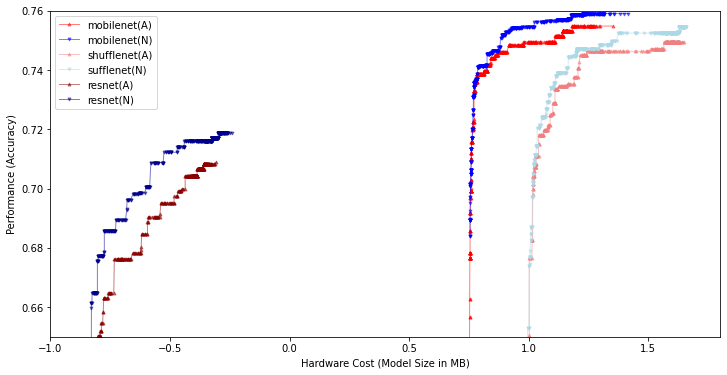

In [19]:
plt.rcParams['figure.figsize'] = (12,6)
plt.plot(np.log(x_1_mbn),y_1_mbn,color='red',marker='^',markersize=3,alpha=0.5,linewidth=1,label='mobilenet(A)')
plt.plot(np.log(x_2_mbn),y_2_mbn,color='blue',marker='v',markersize=3,alpha=0.5,linewidth=1,label='mobilenet(N)')

plt.plot(np.log(x_1_sfn),y_1_sfn,color='lightcoral',marker='^',markersize=3,alpha=0.5,linewidth=1,label='shufflenet(A)')
plt.plot(np.log(x_2_sfn),y_2_sfn,color='lightblue',marker='v',markersize=3,alpha=0.5,linewidth=1,label='sufflenet(N)')

plt.plot(np.log(x_1_rsn),y_1_rsn,color='darkred',marker='^',markersize=3,alpha=0.5,linewidth=1,label='resnet(A)')
plt.plot(np.log(x_2_rsn),y_2_rsn,color='darkblue',marker='v',markersize=3,alpha=0.5,linewidth=1,label='resnet(N)')
# plt.scatter(x_1,y_1,color='red',marker='^',s=10,alpha=0.5)
# plt.scatter(x_2,y_2,color='blue',marker='v',s=10,alpha=0.5)
# plt.ylim([0.66,0.76])
# plt.xlim([0.5,3.5])
plt.ylim([0.65,0.76])
plt.xlim([-1,1.8])
plt.xlabel('Hardware Cost (Model Size in MB)')
plt.ylabel('Performance (Accuracy)')
plt.legend()

# plt.ylim([0.7,0.755])
# plt.xlim([2.7,4.0])
#plt.savefig('c100pareto.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

(array([0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

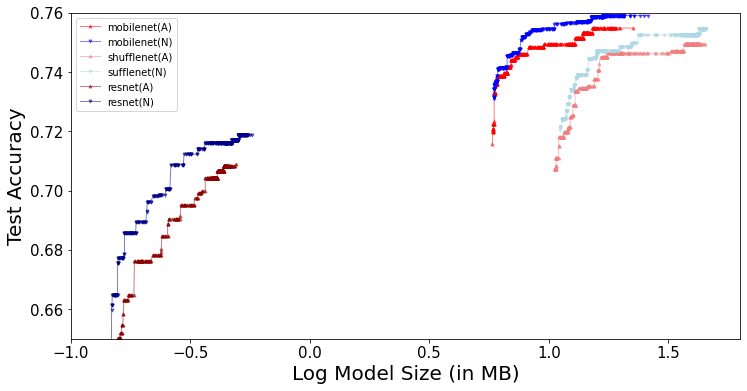

In [31]:
plt.rcParams['figure.figsize'] = (12,6)
plt.plot(np.log(x_1_mbn)[100:],y_1_mbn[100:],color='red',marker='^',markersize=3,alpha=0.5,linewidth=1,label='mobilenet(A)')
plt.plot(np.log(x_2_mbn)[100:],y_2_mbn[100:],color='blue',marker='v',markersize=3,alpha=0.5,linewidth=1,label='mobilenet(N)')

plt.plot(np.log(x_1_sfn)[200:],y_1_sfn[200:],color='lightcoral',marker='^',markersize=3,alpha=0.5,linewidth=1,label='shufflenet(A)')
plt.plot(np.log(x_2_sfn)[200:],y_2_sfn[200:],color='lightblue',marker='v',markersize=3,alpha=0.5,linewidth=1,label='sufflenet(N)')

plt.plot(np.log(x_1_rsn)[0:],y_1_rsn[0:],color='darkred',marker='^',markersize=3,alpha=0.5,linewidth=1,label='resnet(A)')
plt.plot(np.log(x_2_rsn)[0:],y_2_rsn[0:],color='darkblue',marker='v',markersize=3,alpha=0.5,linewidth=1,label='resnet(N)')
# plt.scatter(x_1,y_1,color='red',marker='^',s=10,alpha=0.5)
# plt.scatter(x_2,y_2,color='blue',marker='v',s=10,alpha=0.5)
# plt.ylim([0.66,0.76])
# plt.xlim([0.5,3.5])
plt.ylim([0.65,0.76])
plt.xlim([-1,1.8])
plt.xlabel('Log Model Size (in MB)',fontsize=20)
plt.ylabel('Test Accuracy',fontsize=20)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim([0.7,0.755])
# plt.xlim([2.7,4.0])
#plt.savefig('c100pareto.pdf',transparent=True, bbox_inches='tight', pad_inches=0)